# Tweet Feature Analysis for Retweet Prediction

This notebook analyzes various features to determine their relevance for predicting:
1. Retweet count (regression task)
2. Viral status (binary classification: retweet_count >= 10)

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import datasets
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn.functional as F
from torch import Tensor
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

/home/jqcao/anaconda3/envs/retweet/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load the dataset
raw_dataset = datasets.load_from_disk("data/raw_dataset")

# Add if_viral column to train and eval splits
def add_viral_column(example):
    """Add if_viral column based on retweet_count"""
    example['if_viral'] = example['retweet_count'] >= 10
    return example

# Apply to train and eval splits only
if 'train' in raw_dataset:
    raw_dataset['train'] = raw_dataset['train'].map(
        add_viral_column,
        batched=False,
        num_proc=64,
        load_from_cache_file=False,
    )
    
if 'eval' in raw_dataset:
    raw_dataset['eval'] = raw_dataset['eval'].map(
        add_viral_column,
        batched=False,
        num_proc=64,
        load_from_cache_file=False,
    )

# Convert to pandas for easier analysis
train_df = raw_dataset['train'].to_pandas()
print(f"Training dataset shape: {train_df.shape}")
print(f"\nColumns: {train_df.columns.tolist()}")
print(f"\nFirst few rows:")
train_df.head()

Map (num_proc=64): 100%|██████████| 3000/3000 [00:00<00:00, 8421.72 examples/s]


Training dataset shape: (662777, 12)

Columns: ['id', 'timestamp', 'retweet_count', 'user_verified', 'user_statuses_count', 'user_followers_count', 'user_friends_count', 'user_mentions', 'urls', 'hashtags', 'text', 'if_viral']

First few rows:


,id,timestamp,retweet_count,user_verified,user_statuses_count,user_followers_count,user_friends_count,user_mentions,urls,hashtags,text,if_viral
0,0,1588696955143,0,False,68460,1101,1226,None,None,None,Smh I give up,False
1,1,1588464948124,0,False,309,51,202,None,None,None,"Most of us are Human Beings, but I think you m...",False
2,2,1588634673360,0,False,3241,1675,2325,None,None,None,"Old dirty tricks Trump, at it again...like we ...",False
3,3,1588433158672,0,False,32327,667,304,None,None,None,Seriously..... I worked 86 hours my last check...,False
4,4,1588582751599,0,False,581,42,127,None,None,None,May ALMIGHTY ALLAH have mercy on us all. Only ...,False


## 1. Data Overview and Basic Statistics

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 662777 entries, 0 to 662776
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   id                    662777 non-null  int64 
 1   timestamp             662777 non-null  int64 
 2   retweet_count         662777 non-null  int64 
 3   user_verified         662777 non-null  bool  
 4   user_statuses_count   662777 non-null  int64 
 5   user_followers_count  662777 non-null  int64 
 6   user_friends_count    662777 non-null  int64 
 7   user_mentions         54074 non-null   object
 8   urls                  213164 non-null  object
 9   hashtags              72124 non-null   object
 10  text                  662777 non-null  object
 11  if_viral              662777 non-null  bool  
dtypes: bool(2), int64(6), object(4)
memory usage: 51.8+ MB
None


Retweet Count Statistics:
count    662777.000000
mean        147.422261
std        2969.171382

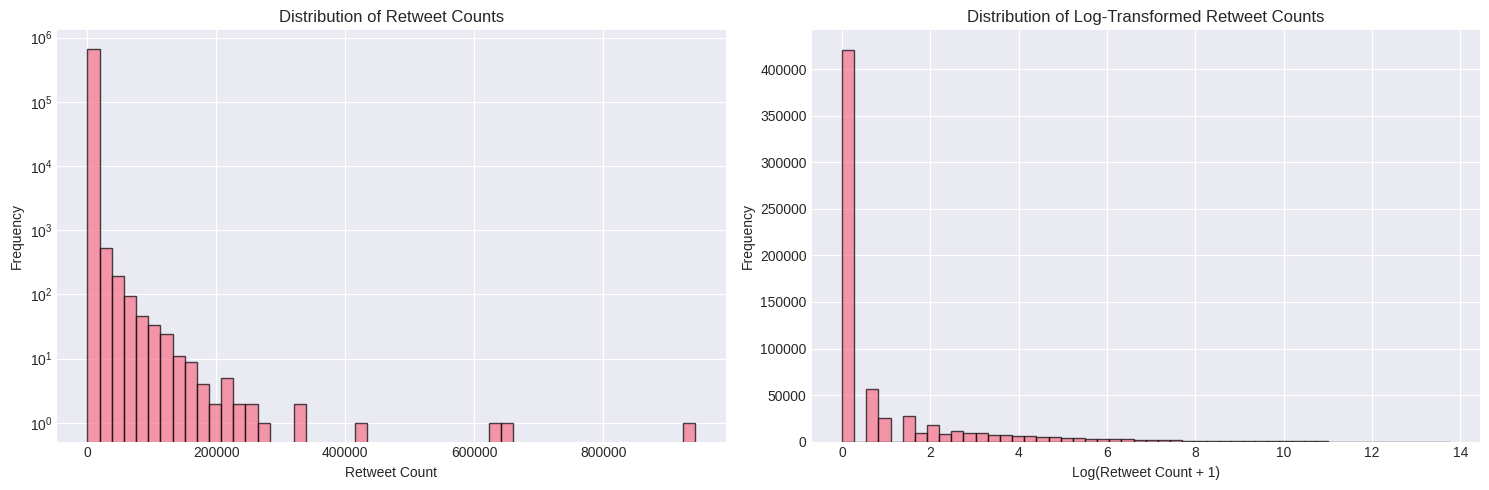

In [3]:
# Basic statistics
print("Dataset Info:")
print(train_df.info())
print("\n" + "="*50 + "\n")

# Retweet count distribution
print(f"Retweet Count Statistics:")
print(train_df['retweet_count'].describe())
print(f"\nViral tweets (>=10 retweets): {train_df['if_viral'].sum()} ({train_df['if_viral'].mean()*100:.2f}%)")

# Visualize retweet distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Distribution of retweet counts
axes[0].hist(train_df['retweet_count'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Retweet Count')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Retweet Counts')
axes[0].set_yscale('log')

# Log-transformed distribution
axes[1].hist(np.log1p(train_df['retweet_count']), bins=50, edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Log(Retweet Count + 1)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Log-Transformed Retweet Counts')

plt.tight_layout()
plt.show()

## 2. Feature Engineering

In [5]:
# Create feature engineering function
def engineer_features(df):
    """Extract and engineer features from the dataset"""
    df_features = df.copy()
    
    # 1. Timestamp features
    df_features['timestamp_dt'] = pd.to_datetime(df_features['timestamp'], unit='ms')
    df_features['hour'] = df_features['timestamp_dt'].dt.hour
    df_features['day_of_week'] = df_features['timestamp_dt'].dt.dayofweek
    df_features['is_weekend'] = (df_features['day_of_week'] >= 5).astype(int)
    
    # Time intervals between consecutive tweets (if ordered by time)
    df_features = df_features.sort_values('timestamp')
    df_features['time_since_last_tweet'] = df_features['timestamp'].diff()
    df_features['time_since_last_tweet'].fillna(0, inplace=True)
    
    # 2. Count features for mentions, URLs, and hashtags
    df_features['mention_count'] = df_features['user_mentions'].apply(
        lambda x: 0 if pd.isna(x) else len(str(x).split(','))
    )
    df_features['url_count'] = df_features['urls'].apply(
        lambda x: 0 if pd.isna(x) else len(str(x).split(','))
    )
    df_features['hashtag_count'] = df_features['hashtags'].apply(
        lambda x: 0 if pd.isna(x) else len(str(x).split(','))
    )
    
    # 3. User feature ratios
    df_features['follower_friend_ratio'] = df_features['user_followers_count'] / (df_features['user_friends_count'] + 1)
    df_features['tweets_per_follower'] = df_features['user_statuses_count'] / (df_features['user_followers_count'] + 1)
    
    # 4. Text features
    df_features['text_length'] = df_features['text'].str.len()
    df_features['word_count'] = df_features['text'].str.split().str.len()
    
    # 5. Binary features
    df_features['has_mentions'] = (df_features['mention_count'] > 0).astype(int)
    df_features['has_urls'] = (df_features['url_count'] > 0).astype(int)
    df_features['has_hashtags'] = (df_features['hashtag_count'] > 0).astype(int)
    
    return df_features

# Apply feature engineering
train_features = engineer_features(train_df)
print("Features created successfully!")
print(f"\nNew features added:")
new_cols = [col for col in train_features.columns if col not in train_df.columns]
print(new_cols)

Features created successfully!

New features added:
['timestamp_dt', 'hour', 'day_of_week', 'is_weekend', 'time_since_last_tweet', 'mention_count', 'url_count', 'hashtag_count', 'follower_friend_ratio', 'tweets_per_follower', 'text_length', 'word_count', 'has_mentions', 'has_urls', 'has_hashtags']


## 3. Feature Correlation Analysis

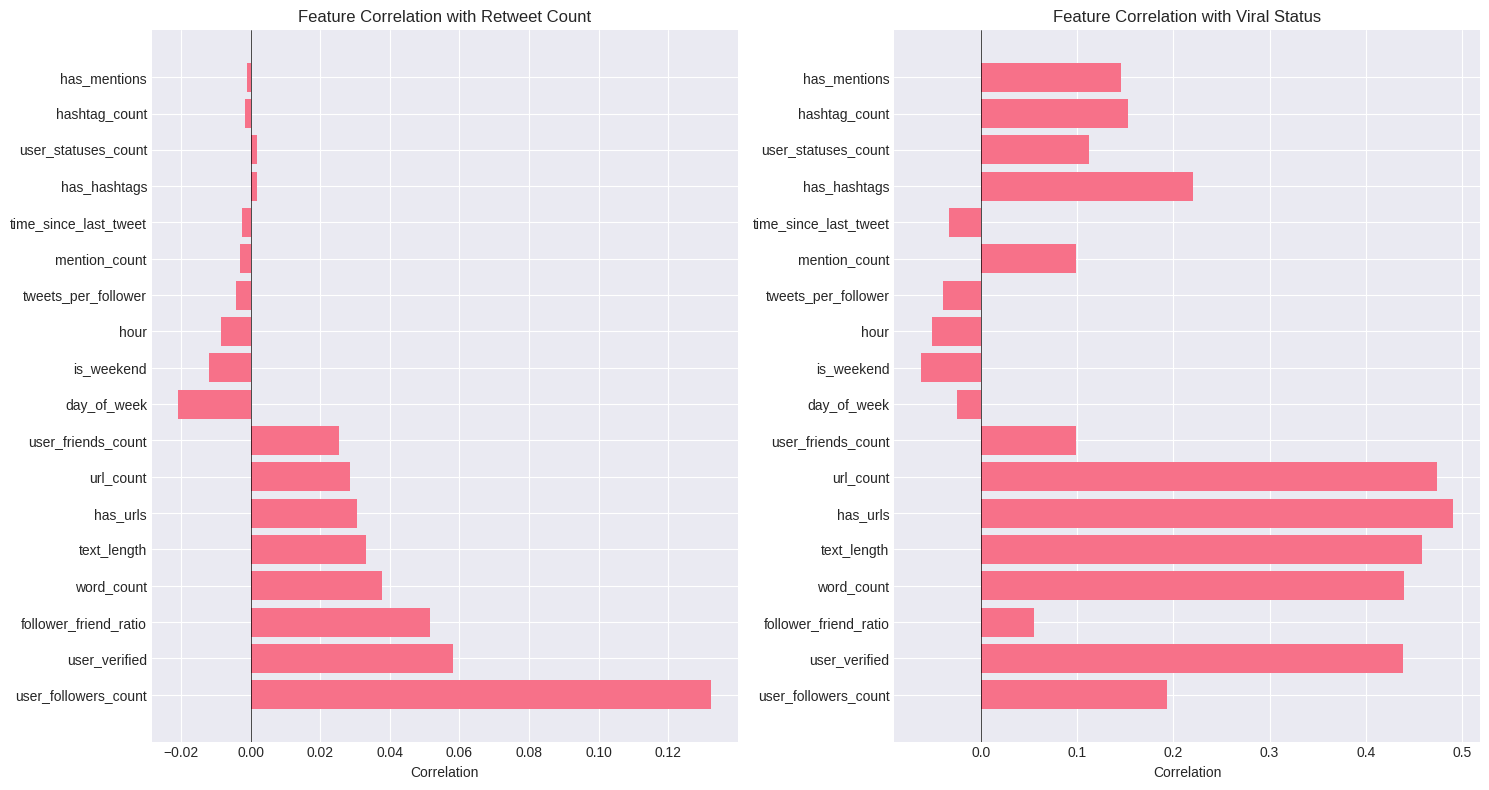

Top 10 features by absolute correlation with retweet_count:
                       retweet_count_corr
user_followers_count             0.132320
user_verified                    0.058050
follower_friend_ratio            0.051628
word_count                       0.037792
text_length                      0.033029
has_urls                         0.030636
url_count                        0.028512
user_friends_count               0.025446
day_of_week                     -0.020807
is_weekend                      -0.011953


In [6]:
# Select numerical features for correlation analysis
numerical_features = [
    'user_verified', 'user_statuses_count', 'user_followers_count', 'user_friends_count',
    'hour', 'day_of_week', 'is_weekend', 'time_since_last_tweet',
    'mention_count', 'url_count', 'hashtag_count',
    'follower_friend_ratio', 'tweets_per_follower',
    'text_length', 'word_count',
    'has_mentions', 'has_urls', 'has_hashtags'
]

# Calculate correlations with retweet_count and if_viral
correlations = pd.DataFrame()
correlations['retweet_count_corr'] = train_features[numerical_features].corrwith(train_features['retweet_count'])
correlations['if_viral_corr'] = train_features[numerical_features].corrwith(train_features['if_viral'])
correlations['abs_retweet_corr'] = correlations['retweet_count_corr'].abs()
correlations = correlations.sort_values('abs_retweet_corr', ascending=False)

# Visualize correlations
fig, axes = plt.subplots(1, 2, figsize=(15, 8))

# Correlation with retweet_count
y_pos = np.arange(len(correlations))
axes[0].barh(y_pos, correlations['retweet_count_corr'])
axes[0].set_yticks(y_pos)
axes[0].set_yticklabels(correlations.index)
axes[0].set_xlabel('Correlation')
axes[0].set_title('Feature Correlation with Retweet Count')
axes[0].axvline(x=0, color='black', linestyle='-', linewidth=0.5)

# Correlation with if_viral
axes[1].barh(y_pos, correlations['if_viral_corr'])
axes[1].set_yticks(y_pos)
axes[1].set_yticklabels(correlations.index)
axes[1].set_xlabel('Correlation')
axes[1].set_title('Feature Correlation with Viral Status')
axes[1].axvline(x=0, color='black', linestyle='-', linewidth=0.5)

plt.tight_layout()
plt.show()

print("Top 10 features by absolute correlation with retweet_count:")
print(correlations[['retweet_count_corr']].head(10))

## 4. Mutual Information Analysis

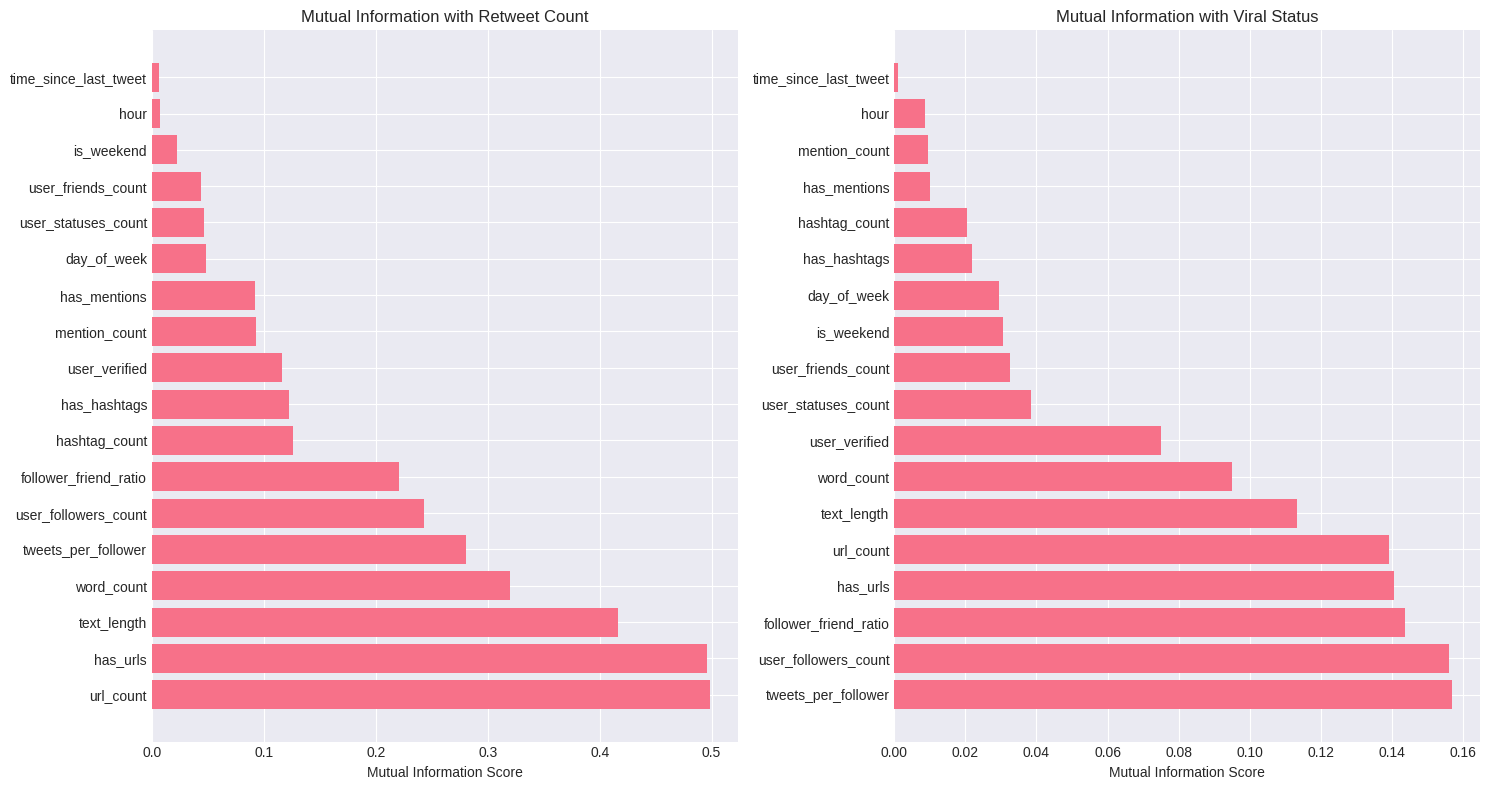

Top 10 features by mutual information with retweet_count:
                  feature  mi_retweet_count
9               url_count          0.498220
16               has_urls          0.495525
13            text_length          0.416022
14             word_count          0.319517
12    tweets_per_follower          0.280850
2    user_followers_count          0.242981
11  follower_friend_ratio          0.220674
10          hashtag_count          0.125888
17           has_hashtags          0.122516
0           user_verified          0.115869


In [7]:
# Prepare data for mutual information analysis
X = train_features[numerical_features].fillna(0)
y_regression = train_features['retweet_count']
y_classification = train_features['if_viral']

# Calculate mutual information
mi_regression = mutual_info_regression(X, y_regression, random_state=42)
mi_classification = mutual_info_classif(X, y_classification, random_state=42)

# Create DataFrame for visualization
mi_scores = pd.DataFrame({
    'feature': numerical_features,
    'mi_retweet_count': mi_regression,
    'mi_viral': mi_classification
}).sort_values('mi_retweet_count', ascending=False)

# Visualize mutual information scores
fig, axes = plt.subplots(1, 2, figsize=(15, 8))

# MI with retweet_count
y_pos = np.arange(len(mi_scores))
axes[0].barh(y_pos, mi_scores['mi_retweet_count'])
axes[0].set_yticks(y_pos)
axes[0].set_yticklabels(mi_scores['feature'])
axes[0].set_xlabel('Mutual Information Score')
axes[0].set_title('Mutual Information with Retweet Count')

# MI with viral status
mi_scores_viral = mi_scores.sort_values('mi_viral', ascending=False)
y_pos = np.arange(len(mi_scores_viral))
axes[1].barh(y_pos, mi_scores_viral['mi_viral'])
axes[1].set_yticks(y_pos)
axes[1].set_yticklabels(mi_scores_viral['feature'])
axes[1].set_xlabel('Mutual Information Score')
axes[1].set_title('Mutual Information with Viral Status')

plt.tight_layout()
plt.show()

print("Top 10 features by mutual information with retweet_count:")
print(mi_scores[['feature', 'mi_retweet_count']].head(10))

## 5. Individual Feature Analysis

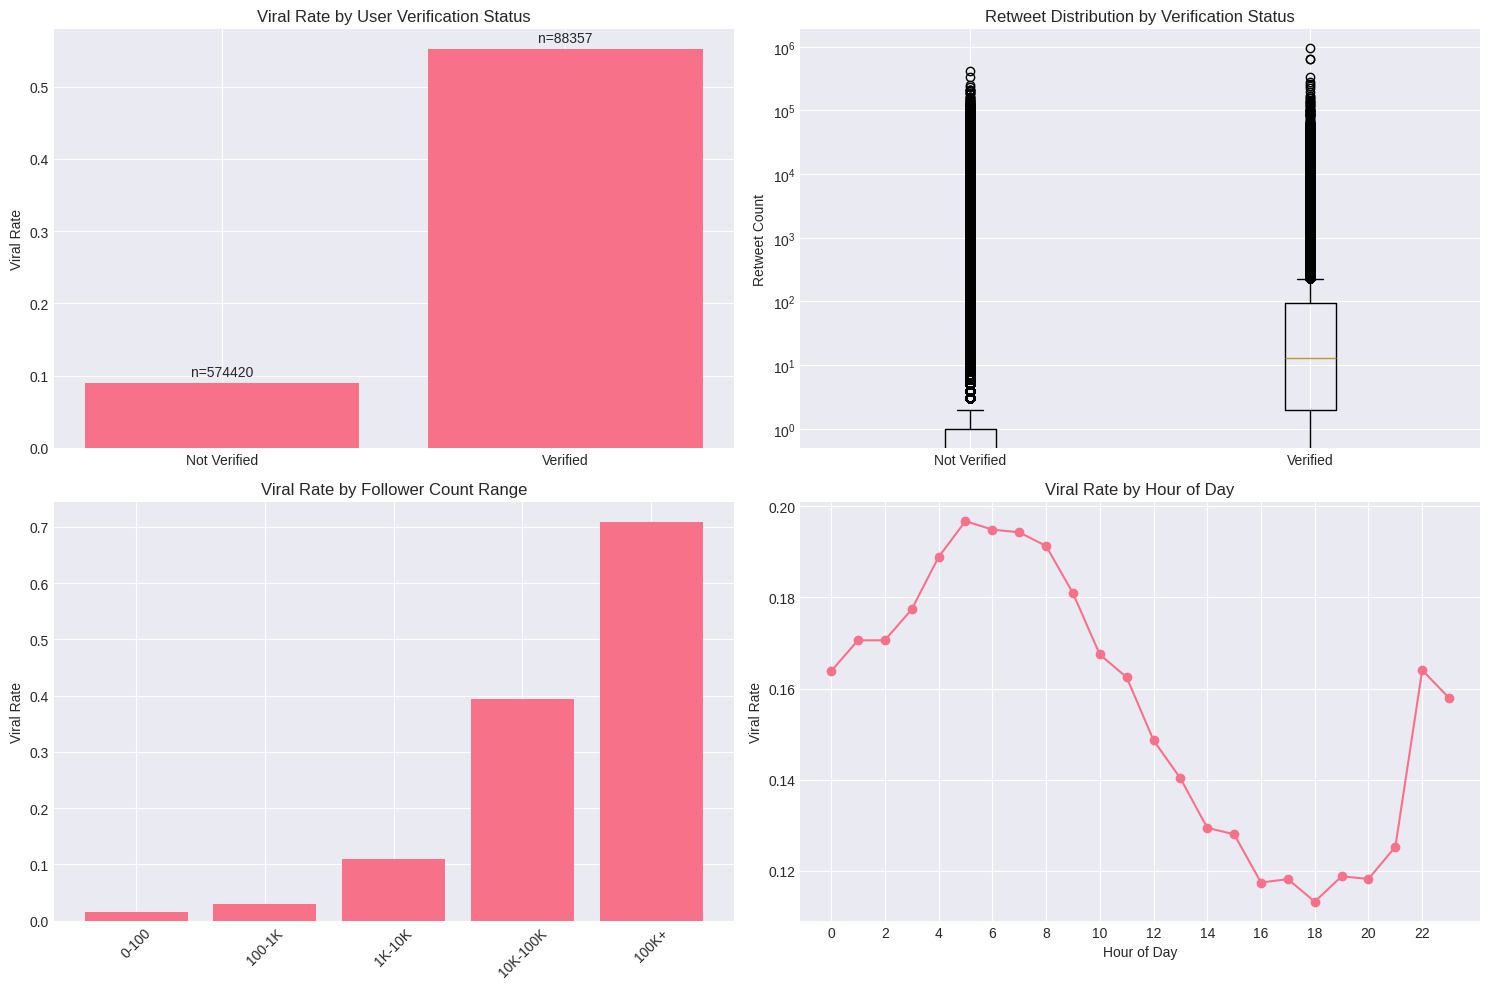

In [8]:
# Analyze user verification impact
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Viral rate by verification status
viral_by_verified = train_features.groupby('user_verified')['if_viral'].agg(['mean', 'count'])
axes[0, 0].bar(['Not Verified', 'Verified'], viral_by_verified['mean'])
axes[0, 0].set_ylabel('Viral Rate')
axes[0, 0].set_title('Viral Rate by User Verification Status')
for i, (count, rate) in enumerate(zip(viral_by_verified['count'], viral_by_verified['mean'])):
    axes[0, 0].text(i, rate + 0.01, f'n={count}', ha='center')

# Average retweets by verification status
axes[0, 1].boxplot([train_features[train_features['user_verified']==0]['retweet_count'],
                    train_features[train_features['user_verified']==1]['retweet_count']],
                   labels=['Not Verified', 'Verified'])
axes[0, 1].set_ylabel('Retweet Count')
axes[0, 1].set_title('Retweet Distribution by Verification Status')
axes[0, 1].set_yscale('log')

# Follower count impact
follower_bins = [0, 100, 1000, 10000, 100000, float('inf')]
follower_labels = ['0-100', '100-1K', '1K-10K', '10K-100K', '100K+']
train_features['follower_bin'] = pd.cut(train_features['user_followers_count'], 
                                       bins=follower_bins, labels=follower_labels)
viral_by_followers = train_features.groupby('follower_bin')['if_viral'].agg(['mean', 'count'])
axes[1, 0].bar(range(len(viral_by_followers)), viral_by_followers['mean'])
axes[1, 0].set_xticks(range(len(viral_by_followers)))
axes[1, 0].set_xticklabels(viral_by_followers.index, rotation=45)
axes[1, 0].set_ylabel('Viral Rate')
axes[1, 0].set_title('Viral Rate by Follower Count Range')

# Time of day impact
viral_by_hour = train_features.groupby('hour')['if_viral'].mean()
axes[1, 1].plot(viral_by_hour.index, viral_by_hour.values, marker='o')
axes[1, 1].set_xlabel('Hour of Day')
axes[1, 1].set_ylabel('Viral Rate')
axes[1, 1].set_title('Viral Rate by Hour of Day')
axes[1, 1].set_xticks(range(0, 24, 2))
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

## 6. Content Features Analysis

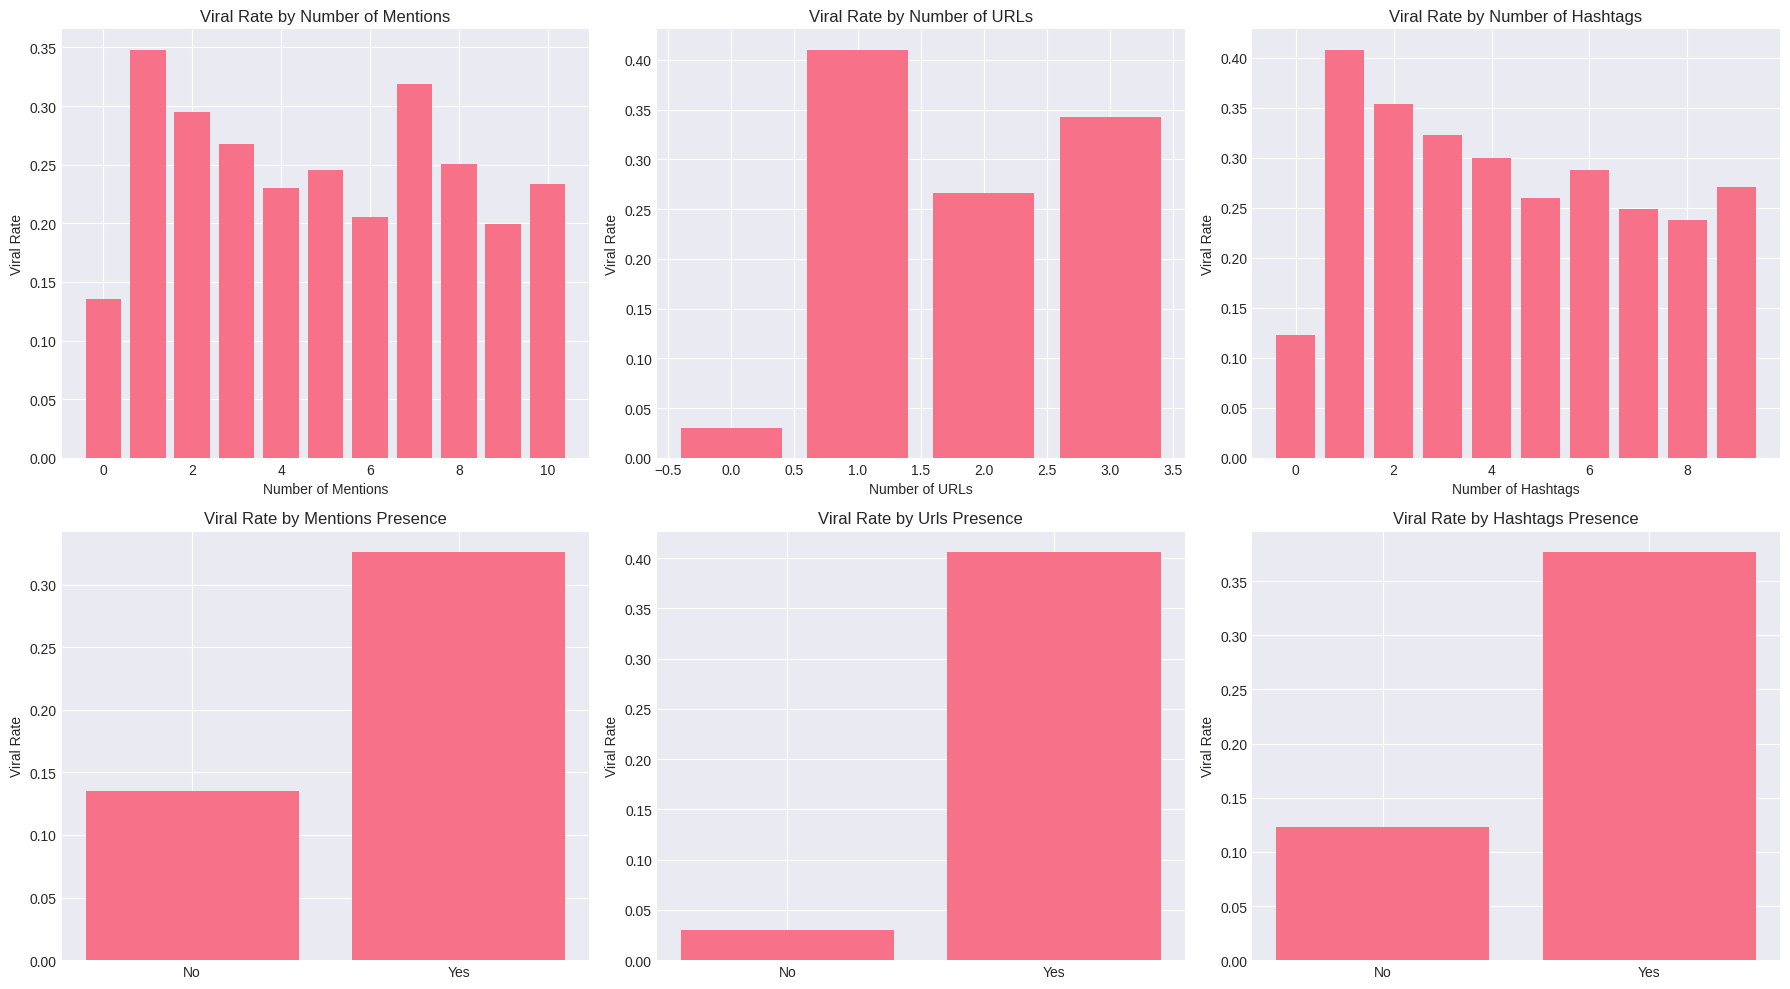

In [9]:
# Analyze impact of mentions, URLs, and hashtags
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Mention count impact
mention_viral = train_features.groupby('mention_count')['if_viral'].agg(['mean', 'count'])
mention_viral = mention_viral[mention_viral['count'] > 50]  # Filter for sufficient samples
axes[0, 0].bar(mention_viral.index, mention_viral['mean'])
axes[0, 0].set_xlabel('Number of Mentions')
axes[0, 0].set_ylabel('Viral Rate')
axes[0, 0].set_title('Viral Rate by Number of Mentions')

# URL count impact
url_viral = train_features.groupby('url_count')['if_viral'].agg(['mean', 'count'])
url_viral = url_viral[url_viral['count'] > 50]
axes[0, 1].bar(url_viral.index, url_viral['mean'])
axes[0, 1].set_xlabel('Number of URLs')
axes[0, 1].set_ylabel('Viral Rate')
axes[0, 1].set_title('Viral Rate by Number of URLs')

# Hashtag count impact
hashtag_viral = train_features.groupby('hashtag_count')['if_viral'].agg(['mean', 'count'])
hashtag_viral = hashtag_viral[hashtag_viral['count'] > 50]
axes[0, 2].bar(hashtag_viral.index, hashtag_viral['mean'])
axes[0, 2].set_xlabel('Number of Hashtags')
axes[0, 2].set_ylabel('Viral Rate')
axes[0, 2].set_title('Viral Rate by Number of Hashtags')

# Binary presence analysis
binary_features = ['has_mentions', 'has_urls', 'has_hashtags']
for i, feature in enumerate(binary_features):
    viral_rates = train_features.groupby(feature)['if_viral'].mean()
    axes[1, i].bar(['No', 'Yes'], viral_rates)
    axes[1, i].set_ylabel('Viral Rate')
    axes[1, i].set_title(f'Viral Rate by {feature.replace("has_", "").title()} Presence')

plt.tight_layout()
plt.show()

## 7. Feature Importance Summary and Recommendations

In [10]:
# Combine all feature importance metrics
feature_importance = pd.DataFrame({
    'feature': numerical_features,
    'corr_retweet': correlations['retweet_count_corr'].reindex(numerical_features),
    'corr_viral': correlations['if_viral_corr'].reindex(numerical_features),
    'mi_retweet': mi_scores.set_index('feature')['mi_retweet_count'].reindex(numerical_features),
    'mi_viral': mi_scores.set_index('feature')['mi_viral'].reindex(numerical_features)
})

# Calculate average importance scores
feature_importance['avg_importance_retweet'] = (
    feature_importance['corr_retweet'].abs() + 
    feature_importance['mi_retweet'] / feature_importance['mi_retweet'].max()
) / 2

feature_importance['avg_importance_viral'] = (
    feature_importance['corr_viral'].abs() + 
    feature_importance['mi_viral'] / feature_importance['mi_viral'].max()
) / 2

# Sort by importance
feature_importance_retweet = feature_importance.sort_values('avg_importance_retweet', ascending=False)
feature_importance_viral = feature_importance.sort_values('avg_importance_viral', ascending=False)

print("\n" + "="*50)
print("FEATURE SELECTION RECOMMENDATIONS")
print("="*50)

print("\nTop 10 Features for Retweet Count Prediction:")
print(feature_importance_retweet[['feature', 'corr_retweet', 'mi_retweet', 'avg_importance_retweet']].head(10))

print("\n\nTop 10 Features for Viral Classification:")
print(feature_importance_viral[['feature', 'corr_viral', 'mi_viral', 'avg_importance_viral']].head(10))


FEATURE SELECTION RECOMMENDATIONS

Top 10 Features for Retweet Count Prediction:
                                     feature  corr_retweet  mi_retweet  \
url_count                          url_count      0.028512    0.498220   
has_urls                            has_urls      0.030636    0.495525   
text_length                      text_length      0.033029    0.416022   
word_count                        word_count      0.037792    0.319517   
user_followers_count    user_followers_count      0.132320    0.242981   
tweets_per_follower      tweets_per_follower     -0.004390    0.280850   
follower_friend_ratio  follower_friend_ratio      0.051628    0.220674   
user_verified                  user_verified      0.058050    0.115869   
hashtag_count                  hashtag_count     -0.001642    0.125888   
has_hashtags                    has_hashtags      0.001778    0.122516   

                       avg_importance_retweet  
url_count                            0.514256  
has_url

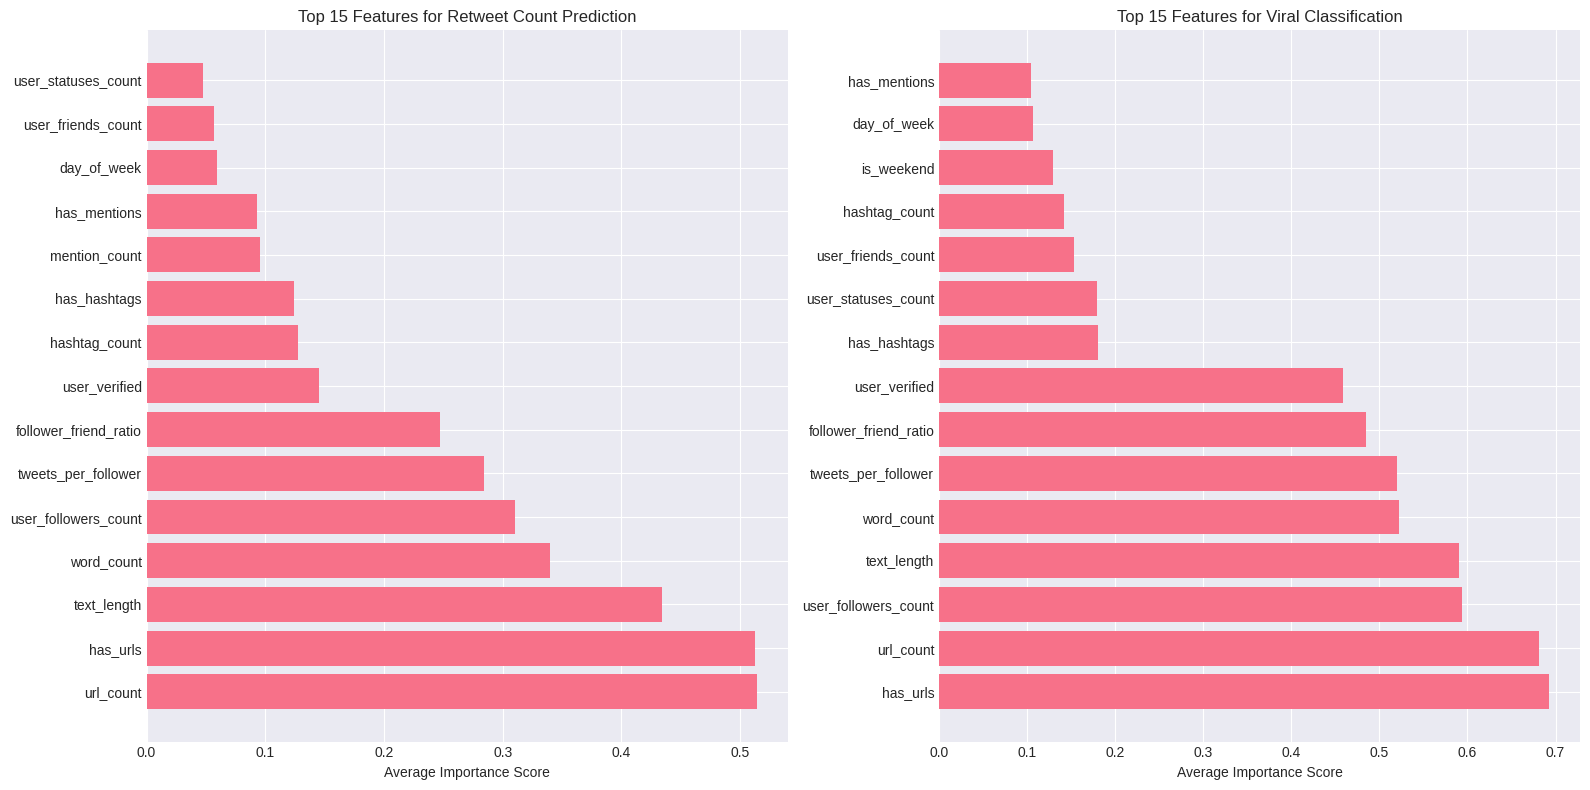

In [11]:
# Final visualization of feature importance
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Top features for retweet prediction
top_features_retweet = feature_importance_retweet.head(15)
y_pos = np.arange(len(top_features_retweet))
axes[0].barh(y_pos, top_features_retweet['avg_importance_retweet'])
axes[0].set_yticks(y_pos)
axes[0].set_yticklabels(top_features_retweet['feature'])
axes[0].set_xlabel('Average Importance Score')
axes[0].set_title('Top 15 Features for Retweet Count Prediction')

# Top features for viral classification
top_features_viral = feature_importance_viral.head(15)
y_pos = np.arange(len(top_features_viral))
axes[1].barh(y_pos, top_features_viral['avg_importance_viral'])
axes[1].set_yticks(y_pos)
axes[1].set_yticklabels(top_features_viral['feature'])
axes[1].set_xlabel('Average Importance Score')
axes[1].set_title('Top 15 Features for Viral Classification')

plt.tight_layout()
plt.show()

# Conclusion:

Selected features:

1. has_url
2. has_hashtags
3. user_verified
4. text_length
5. user_followers_count